# Linear regression and linear classification via incremental gradient descent and mini-batches (numpy vs pytorch)

#### Data and solution from algebra 

The work directory is given from the function.

In [1]:
import deepglmlib.utils as utils
import numpy as np

def towdir(s):
    return (str('./datasets_book/'+s))

In [ ]:
import importlib
importlib.reload(utils)

In [3]:
import numpy as np

n    = 300
beta = np.asarray([-0.5, 3.5]).reshape((2,1))

x  = np.random.uniform(0,1,n).reshape((n,1))
e  = np.random.randn(n).reshape((n,1))/5

X  = np.hstack([np.ones((n,1)), x])
y  = X@beta + e

Xy = np.hstack([x, y])
np.savetxt(towdir("./beta_1d_reglinear300.txt"), beta)
np.savetxt(towdir("./xy_1d_reglinear300.txt"), Xy)

In [4]:
import numpy as np

beta = np.loadtxt(towdir("./beta_1d_reglinear300.txt"))
xy   = np.loadtxt(towdir("./xy_1d_reglinear300.txt"))

beta = beta.reshape((2,1))
x    = xy[:,0].reshape((len(xy),1))
y    = xy[:,1].reshape((len(xy),1))

n    = len(y)
X    = np.hstack([np.ones((n,1)), x])

X.shape, x.shape, y.shape, beta.shape

((300, 2), (300, 1), (300, 1), (2, 1))

In [5]:
print("beta_true=")
print(beta)

beta_true=
[[-0.5]
 [ 3.5]]


In [6]:
betahat_np = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
betahat_np = betahat_np.reshape((2,1))
print("betaha_np=")
print(betahat_np)
print()
print("loss_np=",np.round(np.sum((y-X@betahat_np)**2)/n,5))

betaha_np=
[[-0.5010295 ]
 [ 3.48326088]]

loss_np= 0.03879


#### Loop with data one by one and parameters update via numpy

In [7]:
import copy


In [8]:
#beta_st    = copy.deepcopy(beta_init)
beta_st    = 5.0 * np.ones((2,1))
alpha_t     = 1e-2
n_epoqs     = 20
loss_st_s   = []
grad2_st_s   = []
beta_st_s   = []
beta_st_s.append( copy.deepcopy(beta_st.squeeze()) )

n = len(y)
for epoch in range(0,n_epoqs):
    for i in range(0,n):
        xi = X[i,:].reshape((2,1))
        yi = y[i]
        #grad_C = -2*(yi-xi.T@betat)*xi
        gradient1  = -2*xi@(yi-xi.T@beta_st)
        beta_st  -= alpha_t * gradient1
        beta_st_s.append( copy.deepcopy(beta_st.squeeze()) )
    #print("beta_st=\n",beta_st.ravel())
    loss_st_s.append( np.sum((y-X@beta_st)**2)/n )
    grad2_st_s.append( np.sum((gradient1)**2) )    
tmax_st=epoch

print("beta_st=\n",beta_st)
print()
print("loss_st=",np.round(loss_st_s[tmax_st-1],5))

beta_st=
 [[-0.50809627]
 [ 3.48729191]]

loss_st= 0.03882


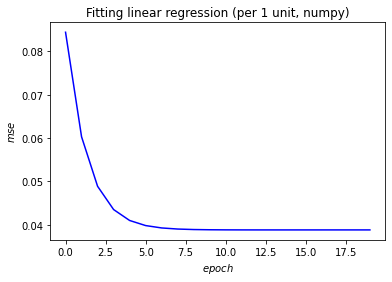

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
utils.f_draw(range(len(loss_st_s)), loss_st_s, "b-", r'$epoch$',r'$mse$',
             "Fitting linear regression (per 1 unit, numpy)",ax)

### Without pytorch: gradient descent (with a mini-batch of B data vectors)

In [10]:
beta_mb = -5.0 * np.ones((2,1))
alpha_t  = 1e-2
n_epoqs  = 20

size_batch=10
i_s       = np.array(np.mgrid[0:n:complex(real=0,imag=size_batch)],dtype=int)

loss_mb_s = []
grad2_mb_s = []
beta_mb_s = []
beta_mb_s.append( copy.deepcopy(beta_mb.squeeze()) )

n = len(y)
for epoch in range(0,n_epoqs):
    for l in range(0,len(i_s)-1):
        b = range(i_s[l]+1*(l>0),i_s[l+1])
        Xb = X[b,:]
        yb = y[b]
        gradientb = -2*np.transpose(Xb)@(yb-Xb @ beta_mb)
        beta_mb -= alpha_t * gradientb
        beta_mb_s.append( copy.deepcopy(beta_mb.squeeze()) )
    loss_mb_s.append( np.sum((y-X@beta_mb)**2)/n )
    grad2_mb_s.append( np.sum((gradientb)**2) )    
tmax_mb=epoch

print("beta_mb=\n",beta_mb)
print()
print("loss_mb=",np.round(loss_mb_s[tmax_mb-1],5))

beta_mb=
 [[-0.48666357]
 [ 3.48627006]]

loss_mb= 0.03904


### With Pytorch: gradient descent (with a mini-batch of B data vectors)

#### Loading the module

In [11]:
import torch

In [12]:
torch.__version__

'1.10.0+cu102'

#### Dataloader and tensors (for cycling the dataset)

In [14]:
from torch.utils.data import DataLoader, TensorDataset

dataset     = TensorDataset( torch.Tensor(X), torch.Tensor(y) )
dataloader  = DataLoader(dataset, batch_size= 10, shuffle=False)

In [15]:
print(dataloader.dataset.tensors[0].numpy().shape,
      dataloader.dataset.tensors[1].numpy().shape)

(300, 2) (300, 1)


#### Autograd and loop for the updates

In [16]:
def loss_mse_Xb_yb_beta(Xb,yb,beta): #loss to minimize
    return (yb-Xb@beta).pow(2).sum()

def f_minimizeloss_update_torch(beta_ag,alpha_t,Xb,yb):
    beta_ag -= alpha_t * beta_ag.grad    

def f_minimizeloss_loop_torch(dataloader,loss,f_update,
                              alpha_t=1e-3,n_epoqs=180,
                              betainit=None):
    loss_ag_s  = []
    beta_ag_s = []
    n          = dataloader.dataset.tensors[0].numpy().shape[0]
    p          = dataloader.dataset.tensors[0].numpy().shape[1]
    
    if betainit is None: betainit = np.zeros((p,1))
    beta_ag   = torch.Tensor(betainit)
    beta_ag.requires_grad_(True)          #required for autograd
    beta_ag_s.append(betainit.squeeze())  #keep init beta in a list
    
    for epoch in range(0,n_epoqs):
        loss_epoch=0
        #for l in range(0,len(i_s)-1):
        for Xb,yb in iter(dataloader):
            loss_b = loss(Xb,yb,beta_ag)
            loss_b.backward()
            #update with gradient of loss from autograd
            with torch.no_grad():
                f_update(beta_ag,alpha_t,Xb,yb)
                beta_ag.grad.zero_()
                #beta_ag -= alpha_t * beta_ag.grad
                #beta_ag.grad.zero_()
            loss_epoch += loss_b
            #keep intermediate value of beta in a list
            beta_ag_s.append(copy.deepcopy( 
                   beta_ag.detach().numpy().squeeze()))  
        loss_ag_s.append(loss_epoch/n)
    tmax_ag = epoch
    return beta_ag, tmax_ag, loss_ag_s, beta_ag_s

In [17]:
loss     = loss_mse_Xb_yb_beta
alpha_t  = 1e-2
n_epochs = 1 #20
f_update = f_minimizeloss_update_torch

beta_ag, tmax_ag, loss_ag_s, beta_ag_s = \
   f_minimizeloss_loop_torch(dataloader,loss,
                             f_update,alpha_t,
                             n_epochs)

print("beta_ag=\n",beta_ag)
print()
print(f"loss={loss_ag_s[tmax_ag]:1.5f}")

beta_ag=
 tensor([[0.5251],
        [1.4533]], requires_grad=True)

loss=0.66406


In [18]:
beta_ag = beta_ag.detach().numpy()

### Visualisation of the trajectory of the parameters converging to a solution

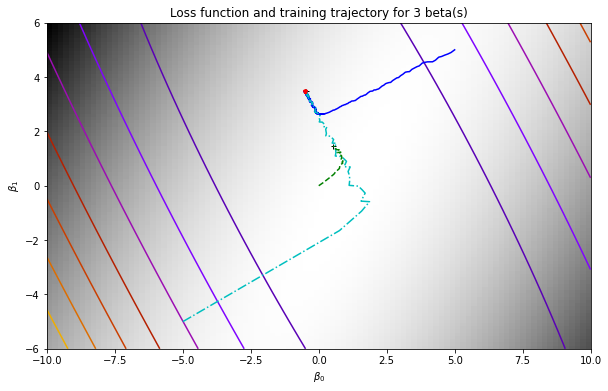

In [19]:
# %matplotlib inline
import matplotlib.pyplot as plt

def f_MSE(betahat):
    yhat = X @ betahat
    return np.sum((y-yhat)**2) / len(yhat)

def f_draw_mse2d_betas(Xmin,Xmax,Ymin,Ymax,f_,betahat,
                       beta_s_list, marker_list):
    XX, YY = np.mgrid[Xmin:Xmax:100j, Ymin:Ymax:100j]
    ZZ=0*XX
    
    for k in range(0,100):
        for l in range(0,100):
            betakl = [XX[k,l],YY[k,l]]
            ZZ[k,l] = f_(betakl)
    
    plt.imshow(ZZ.T, cmap=plt.cm.gray_r, 
               extent=[Xmin, Xmax, Ymin, Ymax],)
               #origin='lower')
    
    plt.contour(XX, YY, ZZ, cmap=plt.cm.gnuplot)
    plt.xlabel(r'$\beta_0$')
    plt.ylabel(r'$\beta_1$')
    plt.title(f'Loss function and training trajectory for '+\
              str(len(beta_s_list)) +' beta(s)')
    
    for beta_s in iter(beta_s_list):
        plt.plot(np.asarray(beta_s)[-1,0], 
                 np.asarray(beta_s)[-1,1], 'k+', markersize=5)
    
    for beta_s, marker in iter(zip(beta_s_list,marker_list)):
        plt.plot(np.asarray(beta_s)[:,0], np.asarray(beta_s)[:,1],
                 marker, markersize=0.8)
    
    plt.plot(betahat[0], betahat[1], 'rp', markersize=5)
    plt.show()
    
##
plt.figure(figsize=(20,6))
f_draw_mse2d_betas(-10.0,10.0,-6.0,6.0, f_MSE, betahat_np,
      [beta_st_s, beta_mb_s, beta_ag_s],
      ['b-', 'c-.', 'g--'])

## Logistic regression with updates from Pytorch

### Data

Let first load the dataset.

In [20]:
import numpy as np
xy   = np.loadtxt(towdir("./xy_2d_reglogistic.txt",))
beta = np.loadtxt(towdir("./beta_2d_reglogistic.txt"))

x    = xy[:,[0,1]]
y    = xy[:,2]
n    = len(y)

print(xy.shape,x.shape,y.shape)

(100, 3) (100, 2) (100,)


In [21]:
sum(y==1), sum(y==0)

(48, 52)

### With pytorch

In [22]:
X    = np.hstack([np.ones((n,1)), x])
X.shape

(100, 3)

In [23]:
beta_init  = np.random.randn(3,1) * 2

In [24]:
print("loglik_init=",y.dot(X@beta_init) - np.sum(np.log(1 + np.exp(X@beta_init))))

loglik_init= [-38.29621294]


In [25]:
import numpy as np
import torch # from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset

def loss_crossentropy_Xb_yb_beta(Xb,yb,beta): #loss for a minibatch
    yb=yb.reshape((len(yb),1))
    beta=beta.reshape((len(beta),1))
    XbTbeta = Xb@beta
    l  = torch.sum(torch.log(1+torch.exp(XbTbeta))) - yb.T@XbTbeta
    return l.squeeze()

In [26]:
batch_size = 10

dataset     = TensorDataset( torch.Tensor(X), torch.Tensor(y) )
dataloader  = DataLoader(dataset, batch_size= batch_size, shuffle=False)

In [27]:
loss     = loss_crossentropy_Xb_yb_beta
alpha_t  = 7e-3
n_epochs = 500
f_update = f_minimizeloss_update_torch

betahat_ag, tmax_ag, loss_ag_s, betahat_ag_s = \
   f_minimizeloss_loop_torch(dataloader,loss,f_update,alpha_t,
                             n_epochs,betainit=beta_init)

print("betahat_ag=\n",betahat_ag)
print()
print(f"loss={n*loss_ag_s[tmax_ag].detach():1.5f}")

betahat_ag=
 tensor([[-0.4911],
        [ 3.8634],
        [ 1.2477]], requires_grad=True)

loss=17.96032


In [33]:
betahat_ag = betahat_ag.detach().numpy()
betahat_ag

array([[-1.1000439],
       [ 3.6103797],
       [ 1.1797962]], dtype=float32)